In [1]:
# from __future__ import print_function
%matplotlib inline
# import argparse
# import os
import random
import torch
import torch.nn as nn
# import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataroot = "/content/celeba"
workers = 2
image_size = 64 # 64
batch_size = 16

In [6]:
!unzip  "/content/drive/MyDrive/gans/img_align_celeba.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba

cuda:0
torch.Size([16, 3, 64, 64])
torch.Size([3, 134, 530])
torch.Size([134, 530, 3])


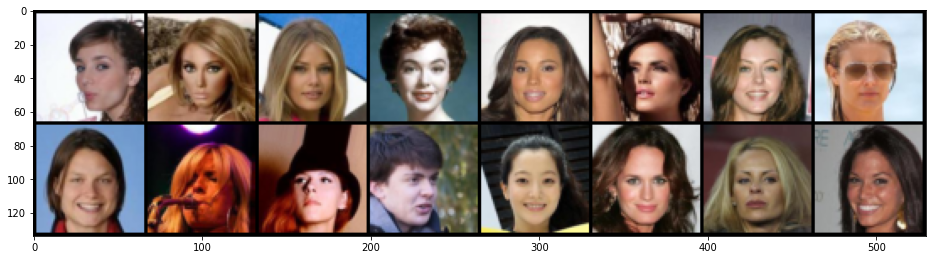

In [36]:
dataset = dset.ImageFolder(root=dataroot, 
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

real_batch, labels = next(iter(data_loader))
print(real_batch.shape)
plt.figure(figsize=(16, 16))
print(vutils.make_grid(real_batch, padding=2, normalize=True).shape)
print(np.transpose(vutils.make_grid(real_batch, padding=2, normalize=True), (1, 2, 0)).shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch, padding=2, normalize=True), (1, 2, 0)))


In [26]:
def initial_weight(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('Batch') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)


In [27]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

In [28]:
# class Generator(nn.Module):
#   def __init__(self):
#     super(Generator, self).__init__()
#     self.main = nn.Sequential(
#         # input is Z, going into a convolution
#         nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#         nn.BatchNorm2d(ngf * 8),
#         nn.ReLU(True),
        
#         # state size. (ngf*8) x 4 x 4
#         nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#         nn.BatchNorm2d(ngf * 4),
#         nn.ReLU(True),
        
#         # state size. (ngf*4) x 8 x 8
#         nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#         nn.BatchNorm2d(ngf * 2),
#         nn.ReLU(True),
        
#         # state size. (ngf*2) x 16 x 16
#         nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#         nn.BatchNorm2d(ngf),
#         nn.ReLU(True),
        
#         # state size. (ngf) x 32 x 32
#         nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#         nn.Tanh()
#         # state size. (nc) x 64 x 64
#     )

#     def forward(self, input):
#       return self.main(input)

# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [29]:
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(initial_weight)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [43]:
netD = Discriminator().to(device)
netD.apply(initial_weight)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [44]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [45]:
device

device(type='cuda', index=0)

In [47]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/12663]	Loss_D: 0.3744	Loss_G: 3.4125	D(x): 0.7972	D(G(z)): 0.0212 / 0.0728
[0/5][50/12663]	Loss_D: 0.1714	Loss_G: 3.8309	D(x): 0.9538	D(G(z)): 0.1004 / 0.0340
[0/5][100/12663]	Loss_D: 0.7544	Loss_G: 8.0582	D(x): 0.9582	D(G(z)): 0.4326 / 0.0005
[0/5][150/12663]	Loss_D: 0.1584	Loss_G: 5.2895	D(x): 0.9823	D(G(z)): 0.1227 / 0.0091
[0/5][200/12663]	Loss_D: 0.8329	Loss_G: 1.4571	D(x): 0.5939	D(G(z)): 0.0883 / 0.3678
[0/5][250/12663]	Loss_D: 0.1056	Loss_G: 3.9437	D(x): 0.9377	D(G(z)): 0.0225 / 0.0333
[0/5][300/12663]	Loss_D: 0.5404	Loss_G: 1.3756	D(x): 0.6549	D(G(z)): 0.0153 / 0.3692
[0/5][350/12663]	Loss_D: 0.0414	Loss_G: 6.1279	D(x): 0.9650	D(G(z)): 0.0044 / 0.0050
[0/5][400/12663]	Loss_D: 0.4222	Loss_G: 3.2305	D(x): 0.7991	D(G(z)): 0.1280 / 0.0555
[0/5][450/12663]	Loss_D: 0.5641	Loss_G: 6.8671	D(x): 0.9994	D(G(z)): 0.3817 / 0.0013
[0/5][500/12663]	Loss_D: 0.4657	Loss_G: 6.3182	D(x): 0.9986	D(G(z)): 0.2350 / 0.0026
[0/5][550/12663]	Loss_D: 0.0848	Loss_G: 4.

In [58]:
(img_list[-1]).shape

torch.Size([3, 530, 530])

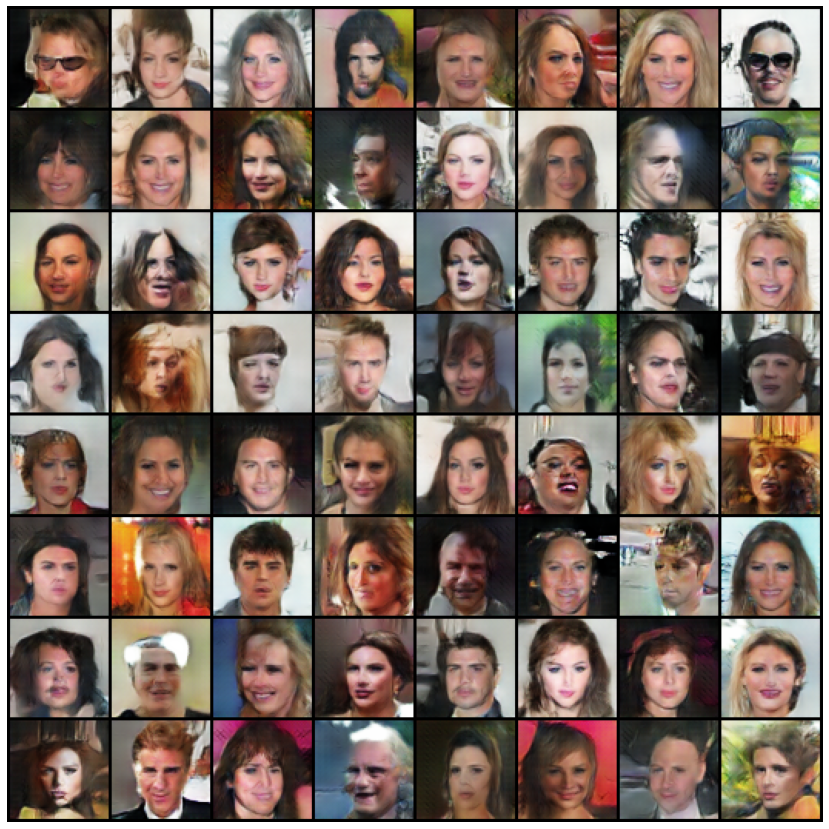

In [59]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(np.transpose(img_list[0], (1, 2, 0)))
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [60]:
fake = netG(fixed_noise).detach().cpu()
fake.shape

torch.Size([64, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


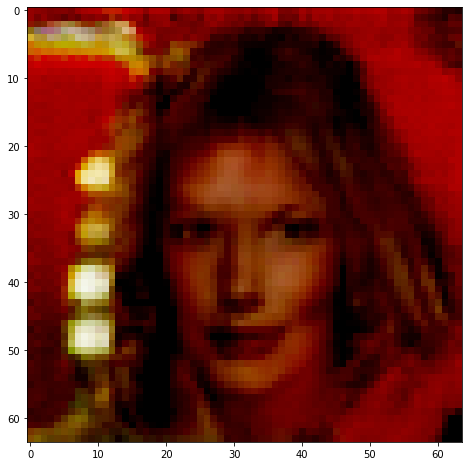

In [69]:
fig = plt.figure(figsize=(8,8))
plt.imshow(np.transpose(fake[5*8+1], (1, 2, 0)))